# ANFEM Data Analysis

In this notebook, we analyze the simulation data. 

## 0 Pacakges

In [27]:
from utils import *
import matplotlib.pyplot as plt
from pathlib import Path
from adios2 import Stream
import re

## 1 Velocity correlation length

### 1.1 Read .pvd data

In [ ]:
filename = "/home/zhengyangliu/Documents/RATSIM/time_step/dt=0.08/results.pvd"
v_list, domain = read_pvd(filename, "velocity")

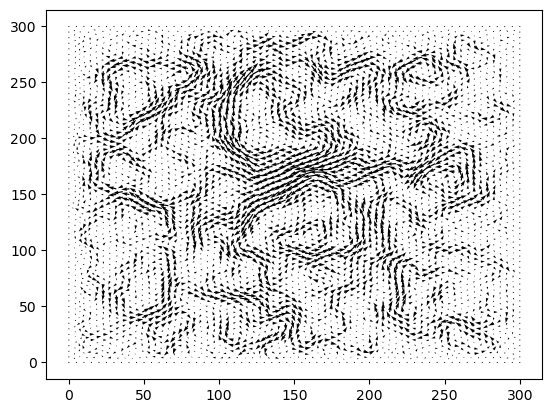

In [31]:
plt.quiver(domain[:, 0], domain[:, 1], v_list[110, :, 0], v_list[110, :, 1])

### 1.2 Interpolate to regular grid

The unstructured grid is not efficient for correlation length calculation. To speed up the calculation, we should interpolate velocity data to a regular "image" grid and then calculate the correlation length. 

In [42]:
v = v_list[100]
X, Y, U, V = interpolate_to_grid(v, domain, resolution=5)

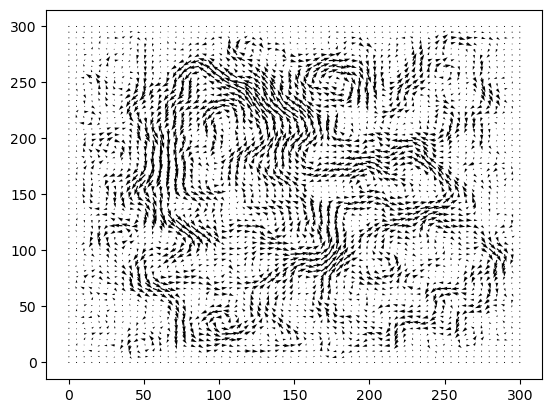

In [43]:
plt.quiver(X, Y, U, V)

### 1.3 Compute correlation length

In [70]:
cl, vacf = corr_length(X, Y, U, V)
print(f"Correlation length = {cl:.1f}")

Correlation length = 21.8


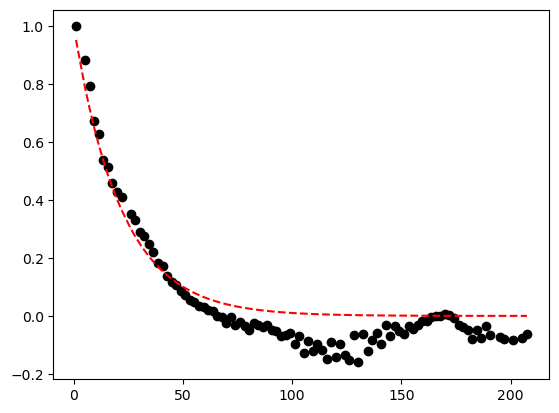

In [ ]:
# check fitting validity
x, y = vacf.values[:, 0], vacf.values[:, 1]
plt.plot(x, y, "o", color="black")
plt.plot(x, np.exp(-x/cl), ls="--", color="red")

## 2 Flow rate

We want to extract the flow rate of the active nematics in the ratchet channel. In a simulation which involves area out of the channel, it is required that we know the location of the channel, so we can crop the velocity data. We could manually find the ROI, but it is more desired to record a ROI when writing the mesh, so that when doing analysis, we can read this information from the .msh file.

In [36]:
class ANSimData:
    def __init__(self, folder):
        self.folder = Path(folder).expanduser().resolve()
        self.pvd_folder = self.folder / "results.pvd"
        self.mesh_dir = self.folder / "mesh.msh"
        self.params_dir = self.folder / "params.json"
        self.data_fields = ["velocity", "pressure", "Q", "scalar_order_parameter"]
        self.data = {}
        for kw in self.data_fields:
            self.data[kw] = []
        self._read_data()
        self._read_roi()

    def _read_data(self):
        """Read data from .pvd data file.

        Args:
        filename -- .pvd data file name (a directory)
        variable -- variable name in the data set.
        
        Returns:
        velocity -- 3D velocity data, axis 0 is the time step.
        domain -- the mesh geometry, coordinates of nodes.
        """
        with Stream(str(self.pvd_folder), "r") as s:
            # steps comes from the stream
            count = 0
            for _ in s.steps():

                # track current step
                # print(f"Current step is {s.current_step()}", end="\r")

                if s.current_step() == 0:
                    self.geometry = s.read("geometry")
                
                for kw in self.data_fields:
                    self.data[kw].append(s.read(kw))

                count += 1
        print(f"{count} steps read.")
    
    def _read_roi(self):
        """Read ROI info from .msh between 2 $ROI lines."""
        inside_roi = False
        with open("/home/zhengyang/Documents/RATSIM/ratchet/N=5/mesh.msh", "r") as f:
            for line in f:
                if "$ROI" in line:
                    if inside_roi:
                        break
                    else:
                        inside_roi = True
                if inside_roi:
                    roi_line = line
        if inside_roi:            
            self.ROI = tuple(map(float, roi_line.split(" ")))
            print(f"ROI found: {self.ROI}")
        else:
            print("ROI not found.")

In [37]:
folder = "~/Documents/RATSIM/ratchet/N=5"
sim = ANSimData(folder)

200 steps read.
ROI found: (32.5, 25.0, 55.0, 82.5)


In [39]:
sim.data["velocity"][0].shape

(5589, 3)

In [48]:
a = (
    (sim.geometry[:, 0] >= sim.ROI[0])
    * (sim.geometry[:, 0] <= sim.ROI[1])
    * (sim.geometry[:, 1] >= sim.ROI[2])
    * (sim.geometry[:, 1] <= sim.ROI[3])
)

In [47]:
a.shape

(5589,)

In [3]:
with open("square.msh", "r") as f:
    lines = f.readlines()

In [4]:
lines

['$MeshFormat\n',
 '4.1 0 8\n',
 '$EndMeshFormat\n',
 '$PhysicalNames\n',
 '2\n',
 '1 1 "Boundary"\n',
 '2 2 "Domain"\n',
 '$EndPhysicalNames\n',
 '$Entities\n',
 '4 4 1 0\n',
 '1 0 0 0 0 \n',
 '2 20 0 0 0 \n',
 '3 20 20 0 0 \n',
 '4 0 20 0 0 \n',
 '1 0 0 0 20 0 0 1 1 2 1 -2 \n',
 '2 20 0 0 20 20 0 1 1 2 2 -3 \n',
 '3 0 20 0 20 20 0 1 1 2 3 -4 \n',
 '4 0 0 0 0 20 0 1 1 2 4 -1 \n',
 '1 0 0 0 20 20 0 1 2 4 1 2 3 4 \n',
 '$EndEntities\n',
 '$Nodes\n',
 '9 510 1 510\n',
 '0 1 0 1\n',
 '1\n',
 '0 0 0\n',
 '0 2 0 1\n',
 '2\n',
 '20 0 0\n',
 '0 3 0 1\n',
 '3\n',
 '20 20 0\n',
 '0 4 0 1\n',
 '4\n',
 '0 20 0\n',
 '1 1 0 19\n',
 '5\n',
 '6\n',
 '7\n',
 '8\n',
 '9\n',
 '10\n',
 '11\n',
 '12\n',
 '13\n',
 '14\n',
 '15\n',
 '16\n',
 '17\n',
 '18\n',
 '19\n',
 '20\n',
 '21\n',
 '22\n',
 '23\n',
 '0.9999999999991025 0 0\n',
 '1.999999999998379 0 0\n',
 '2.99999999999657 0 0\n',
 '3.999999999993654 0 0\n',
 '4.999999999990736 0 0\n',
 '5.99999999998782 0 0\n',
 '6.999999999984902 0 0\n',
 '7.999999999